In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time


from matplotlib import pyplot
import matplotlib.pyplot as plt

from glob import glob as glb

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf
#tf.keras.backend.set_floatx('float64')
np.random.seed(0)
print(tf.__version__) # expected 2.1.0

2.1.0


In [2]:
pix_dimX = 128
pix_dimY = 256
pix_input = 1
pix_output = 2 # velocity
BATCH_SIZE = 1
BUFFER_SIZE = 400



In [3]:
def parser(record):
    keys_to_features = {
        'boundary':tf.io.FixedLenFeature([],tf.string),
        'sflow':tf.io.FixedLenFeature([],tf.string)
    }
    parsed = tf.io.parse_single_example(record, keys_to_features)

    boundary = tf.io.decode_raw(parsed['boundary'], tf.uint8)
    sflow = tf.io.decode_raw(parsed['sflow'], tf.float32)
    boundary = tf.reshape(boundary, [128, 256, 1])
    sflow = tf.reshape(sflow, [128, 256, 2])
    boundary = tf.cast(boundary, tf.float32)
    sflow =  tf.cast(sflow, tf.float32)

    return boundary, sflow

Change the variable **filenames** to data path.

In [5]:
filenames = "GAN_flownet/data/train.tfrecords"
dataset = tf.data.TFRecordDataset(filenames)
dataset = dataset.map(parser)
dataset = dataset.batch(BATCH_SIZE)

In [6]:
def generate_images(boundary_np,sflow_true, model= None):
    if(model != None):
        sflow_generated = model(boundary_np, training=True)
    else:
        sflow_generated = sflow_true
        
    sflow_plot_true =(sflow_true.numpy()).reshape([pix_dimX,pix_dimY,pix_output])
    sflow_plot_generated =(sflow_generated.numpy()).reshape([pix_dimX,pix_dimY,pix_output])
    
    # sflow_plot = np.concatenate([sflow_true, sflow_generated, sflow_true - sflow_generated], axis=1)
    boundary_np_plot = (boundary_np.numpy()).reshape(pix_dimX,pix_dimY)
    boundary_concat = np.concatenate([boundary_np_plot.reshape(1,128,256,1)], axis=2)
    sflow_plot_true = np.sqrt(np.square(sflow_plot_true[:,:,0]) + np.square(sflow_plot_true[:,:,1]))#- 0.5*boundary_concat[0,:,:,0]
    sflow_plot_generated = np.sqrt(np.square(sflow_plot_generated[:,:,0]) + np.square(sflow_plot_generated[:,:,1]))#- 0.5*boundary_concat[0,:,:,0]
       
    display_list = [boundary_np_plot, sflow_plot_true,sflow_plot_generated]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    
    # display it
    plt.figure(figsize=(15,15))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i], cmap = 'gray')
   # plt.axis('off')
    plt.show()

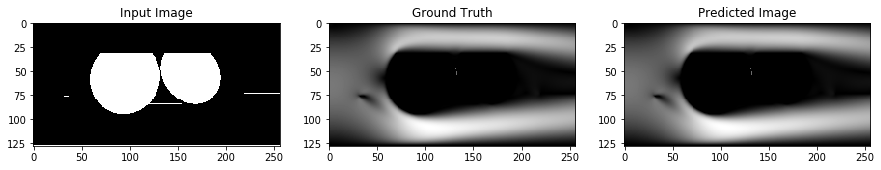

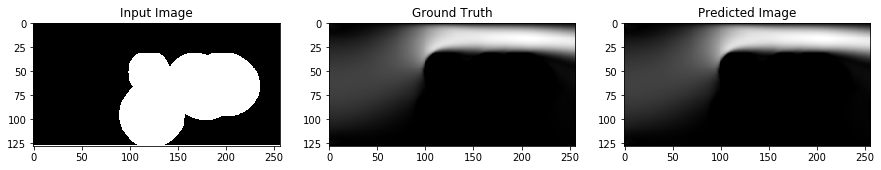

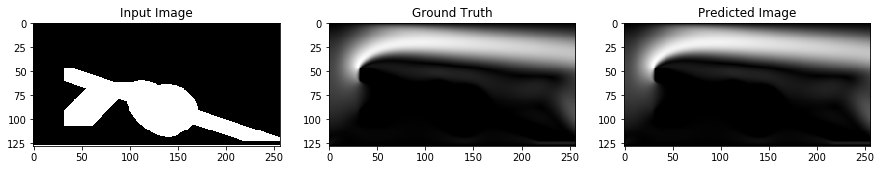

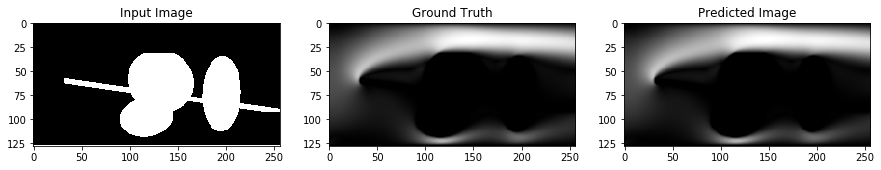

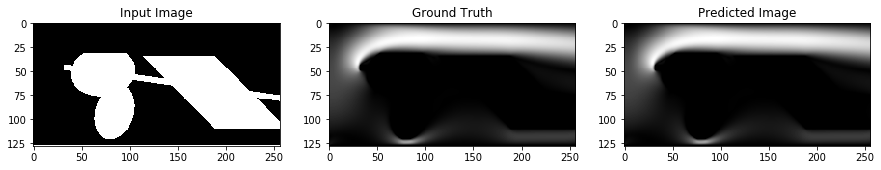

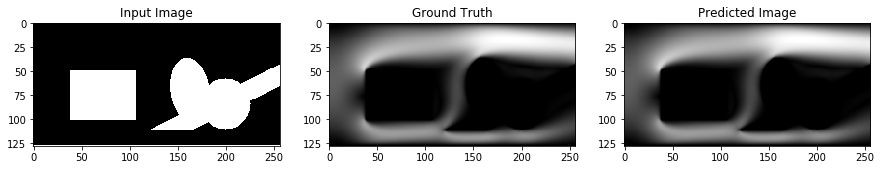

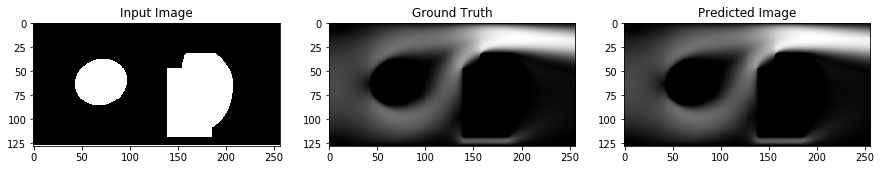

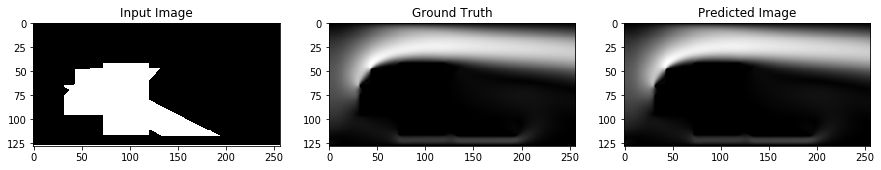

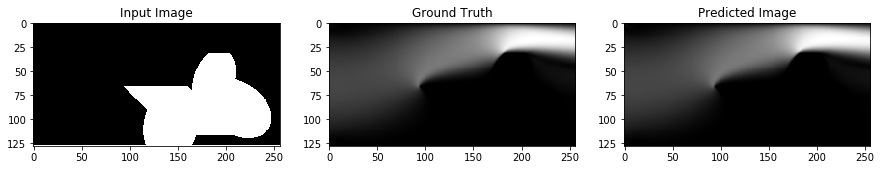

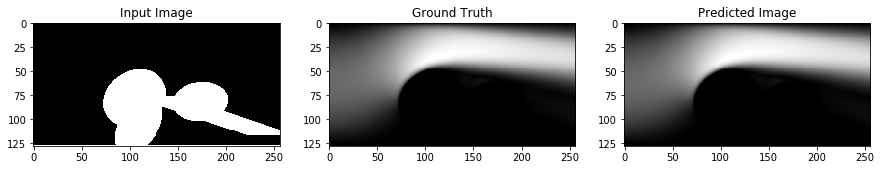

In [8]:
#Note here ground and predicted are same beause model is not initiated and is an hack to avoid runtime failure.
for i,o in dataset.take(10):
    generate_images(i,o)

# Architecture of GAN model

In [9]:
#refer pix2pix tutorial
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def Generator():
  inputs = tf.keras.layers.Input(shape=[pix_dimX,pix_dimY,pix_input], name = 'adityab')

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), 
    downsample(128, 4), 
    downsample(256, 4), 
    downsample(512, 4), 
    downsample(512, 4),
    downsample(512, 4), 
 #   downsample(512, 4), 
    downsample(512, 4), 
  ]

  up_stack = [
#    upsample(512, 4, apply_dropout=True),
    upsample(512, 4, apply_dropout=True), 
    upsample(512, 4, apply_dropout=True),
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(pix_output, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)



In [10]:
generator = Generator()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
adityab (InputLayer)            [(None, 128, 256, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64, 128, 64)  1024        adityab[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 32, 64, 128)  131584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 16, 32, 256)  525312      sequential_1[0][0]               
______________________________________________________________________________________________

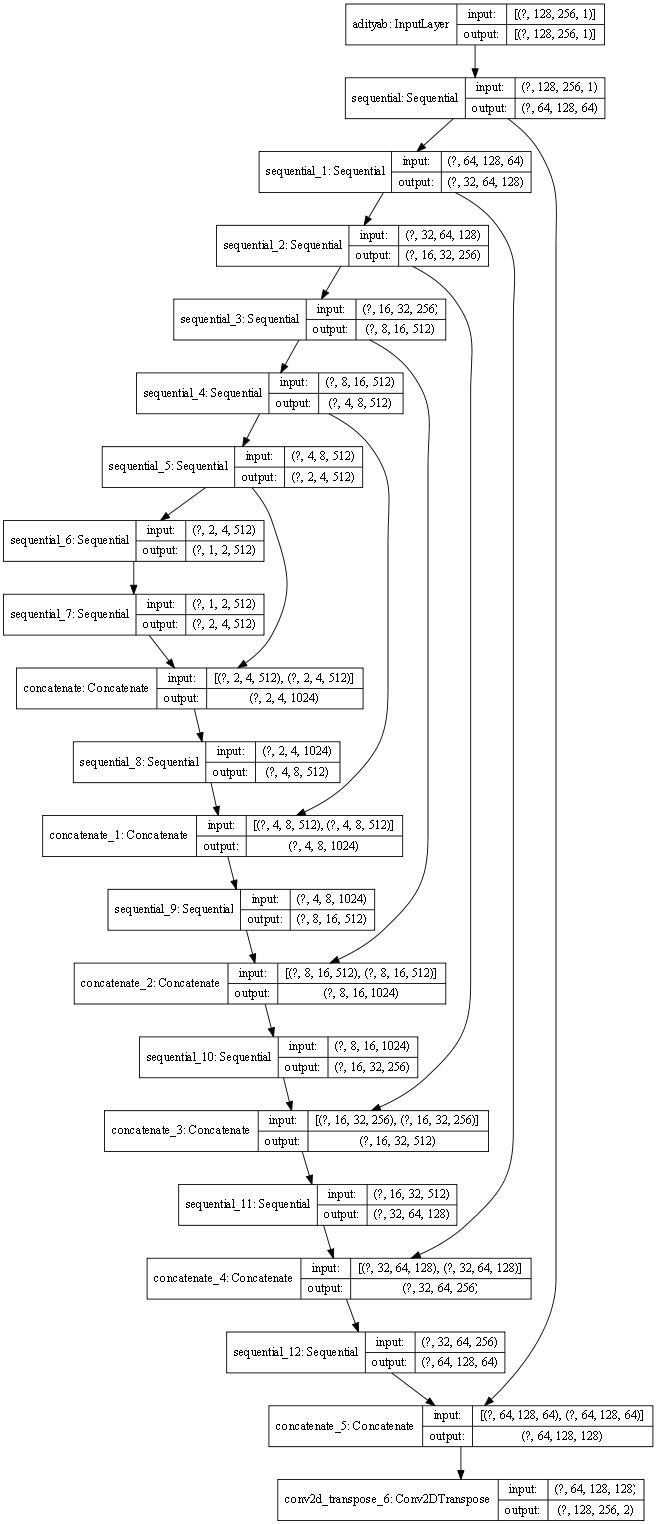

In [11]:
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

# Optimizers

In [12]:
generator_optimizer = tf.keras.optimizers.Adam()# tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


# Loss function and train

In [13]:
# loss function is tested using total_gen_loss= tf.constant(0.) and  tf.constant(1.)
#from tensorflow.keras import backend
def loss_function_generator(y_pred, y_true):

    total_gen_loss = tf.reduce_mean(tf.abs(y_true - y_pred))
    
    return total_gen_loss

# Load old weights (if aplicable)

In [14]:
#generator.load_weights('checkpoints\GAN_without_discriminator\gan_without_discrminator_car_weghits')

# Compile and fit

In [15]:
generator.compile(optimizer= generator_optimizer,
                  loss =loss_function_generator)

In [16]:
Epochs =100

In [17]:
def train():
    setEpochs = int(Epochs/10)
    for i in range(0,setEpochs):
        generator.fit(dataset,  epochs = setEpochs)
        generator.save_weights('checkpoints\VanGogh_Fit_generator_Velocity\VanGogh_weghits')
        for inputI,outputI in dataset.take(5):
            generate_images(inputI,outputI,generator)

In [ ]:
train()

In [ ]:
for inputI,outputI in dataset.take(5):
    generate_images(inputI,outputI,generator)

In [ ]:
generator.save('checkpoints/VanGogh_Fit_generator_Velocity/complete_Model/Vangogh_generator_car.h5')

In [ ]:
generator.save_weights('checkpoints\VanGogh_Fit_generator_Velocity\gan_without_discrminator_car_weghits')